In [1]:
## ALL IMPORTS FOR A NEW NOTEBOOK

import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm
import time

font = {'size'   : 22}

matplotlib.rc('font', **font)

In [2]:
torch_utils.seed_everything(947)

In [3]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
sub_df = pd.read_csv("./sample_submission.csv")

In [4]:
torch_utils.resumetable(train_df)

Dataset Shape: (300000, 25)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,300000,0,1,2,18.19
1,bin_0,int64,0,2,0,0,0,0.55
2,bin_1,int64,0,2,0,1,0,0.82
3,bin_2,int64,0,2,0,0,0,0.96
4,bin_3,object,0,2,T,T,F,1.00
5,bin_4,object,0,2,Y,Y,Y,0.94
6,nom_0,object,0,3,Green,Green,Blue,1.55
7,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid,2.45
8,nom_2,object,0,6,Snake,Hamster,Lion,2.44
9,nom_3,object,0,6,Finland,Russia,Russia,2.45


In [5]:
trainX = train_df.drop(["id", "target"], axis=1)
trainY = train_df.target
testX = test_df.drop(["id"], axis=1)

print(trainX.shape, testX.shape)

(300000, 23) (200000, 23)


In [6]:
%%time
catted = pd.concat([trainX, testX])
catted["ord_5a"] = catted["ord_5"].str[0]
catted["ord_5b"] = catted["ord_5"].str[1]

catted = catted.drop(["ord_5"], axis = 1)

CPU times: user 3.97 s, sys: 419 ms, total: 4.39 s
Wall time: 1.14 s


In [7]:
def run_cv_model(train, test, target, model_fn, params={}, eval_fn=None, label='model', random_state=947):
    kf = ms.KFold(n_splits=5, random_state=random_state)
    fold_splits = kf.split(train, target)
    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros((train.shape[0]))
    i = 1
    
    for dev_index, val_index in fold_splits:
        print('Started ' + label + ' fold ' + str(i) + '/5')
        dev_X, val_X = train[dev_index], train[val_index]
        dev_y, val_y = target[dev_index], target[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y = model_fn(dev_X, dev_y, val_X, val_y, test, params2)
        pred_full_test = pred_full_test + pred_test_y
        pred_train[val_index] = pred_val_y
        if eval_fn is not None:
            cv_score = eval_fn(val_y, pred_val_y)
            cv_scores.append(cv_score)
            print(label + ' cv score {}: {}'.format(i, cv_score))
        i += 1
    print('{} cv scores : {}'.format(label, cv_scores))
    print('{} cv mean score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv std score : {}'.format(label, np.std(cv_scores)))
    pred_full_test = pred_full_test / 5.0
    results = {'label': label,
              'train': pred_train, 'test': pred_full_test,
              'cv': cv_scores}

    return results

In [8]:
from sklearn.linear_model import LogisticRegression
def runLR(train_X, train_y, test_X, test_y, test_X2, params):
    print('Train LR')
    model = LogisticRegression(**params)
    model.fit(train_X, train_y)
    print('Predict 1/2')
    pred_test_y = model.predict_proba(test_X)[:, 1]
    print('Predict 2/2')
    pred_test_y2 = model.predict_proba(test_X2)[:, 1]
    return pred_test_y, pred_test_y2

In [9]:
for col in range(5,10):
    col = "nom_"+str(col)
    train_uniq = set(train_df[col].unique())
    test_uniq = set(test_df[col].unique())
    
    xor_cat = train_uniq ^ test_uniq
    
    if len(xor_cat)>0:
        catted.loc[catted[col].isin(xor_cat), col] = "xor"

In [10]:
ohe = pp.OneHotEncoder(handle_unknown="ignore")

In [11]:
X_oh = catted[catted.columns.difference(["ord_0","ord_1","ord_2","ord_3","ord_4","ord_5a","ord_5b"])]

In [12]:
ohe.fit(X_oh)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

In [13]:
ohc1 = ohe.transform(X_oh)

In [14]:
from sklearn.base import TransformerMixin
from itertools import repeat
import scipy

class ThermometerEncoder(TransformerMixin):
    """
    kaggle.com/superant/oh-my-cat
    Assuming all values are known at fit.
    """
    def __init__(self, sort_key=None):
        self.sort_key = sort_key
        self.value_map_ = None
    
    def fit(self, X, y=None):
        self.value_map_ = {val:i for i, val in enumerate(sorted(X.unique(), key=self.sort_key))}
        return self
    def transform(self, X, y=None):
        values = X.map(self.value_map_)
        possible_values = sorted(self.value_map_.values())
        idx1,idx2 = [],[]
        
        all_indices = np.arange(len(X))
        for idx, val  in enumerate(possible_values[:-1]):
            new_idx = all_indices[values>val]
            idx1.extend(new_idx)
            idx2.extend(repeat(idx, len(new_idx)))
        
        result = scipy.sparse.coo_matrix(([1]*len(idx1), (idx1, idx2)), shape=(len(X), len(possible_values)), dtype="int8")
        return result

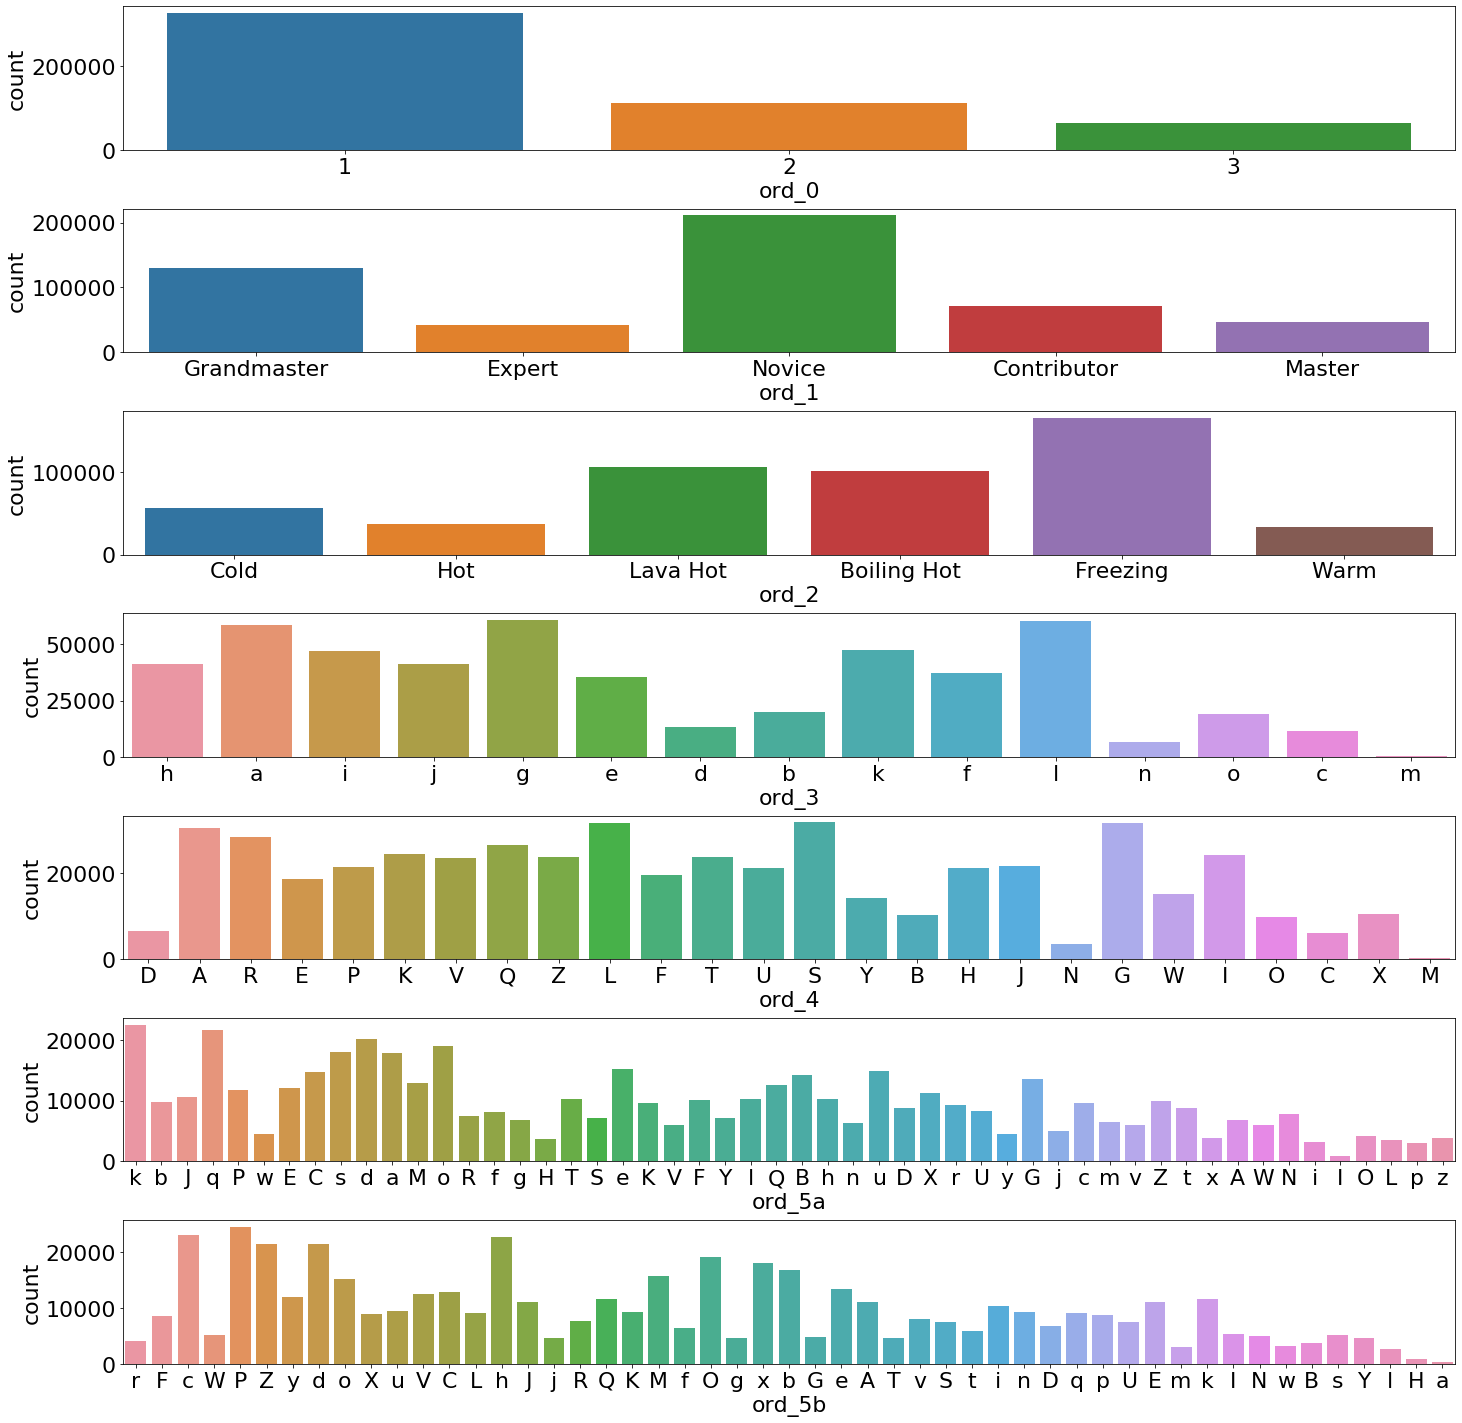

In [15]:
fig, axes = plt.subplots(nrows=len( ["ord_0","ord_1","ord_2","ord_3","ord_4","ord_5a","ord_5b"]),)
fig.set_figheight(20)
fig.set_figwidth(20)
fig.tight_layout()
for idx, col in enumerate(["ord_0","ord_1","ord_2","ord_3","ord_4","ord_5a","ord_5b"]):
    sns.countplot(catted[col], ax = axes[idx])
fig.subplots_adjust(wspace=0.2)

In [16]:
thermos = []
for col in  ["ord_0","ord_1","ord_2","ord_3","ord_4","ord_5a","ord_5b"]:
    if col=="ord_0":
        sort_key = int
    elif col=="ord_1":
        sort_key = ["Novice", "Contributor", "Expert", "Master", "Grandmaster"].index
    elif col=="ord_2":
        sort_key = ["Freezing","Cold", "Warm", "Hot", "Boiling Hot", "Lava Hot"].index
    elif col in ["ord_3", "ord_4", "ord_5a", "ord_5b"]:
        sort_key = str
    elif col in ["day", "month"]:
        sort_key = int
    else:
        raise ValueError(col)
    print(col)
    enc = ThermometerEncoder(sort_key)
    thermos.append(enc.fit_transform(catted[col]))
        

ord_0
ord_1
ord_2
ord_3
ord_4
ord_5a
ord_5b


In [17]:
ohc = scipy.sparse.hstack([ohc1]+thermos).tocsr()

In [18]:
X_train = ohc[:len(train_df)]
X_test = ohc[len(train_df):]
y_train = trainY

In [19]:

lr_params = {'solver': 'lbfgs', 'C': 0.123456789, "max_iter":5000, "verbose":1, "n_jobs":5}
results = run_cv_model(X_train, X_test, y_train, runLR, lr_params, metrics.roc_auc_score, 'lr')

Started lr fold 1/5
Train LR


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  1.9min finished


Predict 1/2
Predict 2/2
lr cv score 1: 0.802038156777567
Started lr fold 2/5
Train LR


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  2.0min finished


Predict 1/2
Predict 2/2
lr cv score 2: 0.8010353829933216
Started lr fold 3/5
Train LR


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  2.0min finished


Predict 1/2
Predict 2/2
lr cv score 3: 0.8080389339267469
Started lr fold 4/5
Train LR


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  2.0min finished


Predict 1/2
Predict 2/2
lr cv score 4: 0.8036169520186435
Started lr fold 5/5
Train LR


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


KeyboardInterrupt: 

In [ ]:
sub_df.target = pd.Series(results["test"])

In [ ]:
sub_df.to_csv("submit.csv", index=False)

In [ ]:
import lightgbm as lgb

In [ ]:
X_train = X_train.astype(float)

X_train, X_valid, y_train, y_valid = ms.train_test_split(X_train, y_train, test_size=0.15)

X_test = X_test.astype(float)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test)
lgb_valid = lgb.Dataset(X_valid, y_valid)

params = {
    "boosting_type":"gbdt",
    "objective":"binary",
    "metric":{"binary_logloss", "auc"},
    "num_leaves": 450,
    "max_depth": 25,
    "min_data_in_leaf":150,
    "learning_rate":0.1,
    "feature_fraction":0.95,
    "bagging_fraction":0.95,
    "baggin_freq":10,
    "lambda_l1":0,
    "lambda_l2":0,
    "min_gain_to_split":0.1,
    "verbose":1,
    "is_unbalance":True
}

In [ ]:
gbm = lgb.train(params, lgb_train, num_boost_round=10000, valid_sets=lgb_valid, early_stopping_rounds=500)

In [ ]:
score = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [ ]:
sub_df.target = pd.Series(score)
sub_df.to_csv("submit.csv", index=False)

In [24]:
#########################################################################################
#https://www.kaggle.com/adaubas/2nd-place-solution-categorical-fe-callenge
def color_and_top(nb_mod, feature, typ, top_n=None):
    
    if top_n is None:
        resu = ["g", nb_mod]
    elif nb_mod > 2*top_n:
        resu = ["r", top_n]
    elif nb_mod > top_n:
        resu =["orange", top_n]
    else: 
        resu = ["g", nb_mod]
    
    title = feature[:20]+" ("+typ[:3]+"-{})".format(nb_mod)
    resu.append(title)
    
    return resu


def plot_multiple_categorical(df, features, col_target=None, top_n=None
                              , nb_subplots_per_row = 4, hspace = 1.3, wspace = 0.5
                              , figheight=15, m_figwidth=4.2, landmark = .01):
    
    sns.set_style('whitegrid')
    
    if not (col_target is None):
        ref = df[col_target].mean() # Reference
    
    plt.figure()
    if len(features) % nb_subplots_per_row >0:
        nb_rows = int(np.floor(len(features) / nb_subplots_per_row)+1)
    else:
        nb_rows = int(np.floor(len(features) / nb_subplots_per_row))
    fig, ax = plt.subplots(nb_rows, nb_subplots_per_row, figsize=(figheight, m_figwidth * nb_rows))
    plt.subplots_adjust(hspace = hspace, wspace = wspace)

    i = 0; n_row=0; n_col=0
    for feature in features:
        
        i += 1
        plt.subplot(nb_rows, nb_subplots_per_row, i)

        dff = df[[feature, col_target]].copy() # I don't want transform data, only study them
        
        # Missing values
        if dff[feature].dtype.name in ["float16", "float32", "float64"]:
            dff[feature].fillna(-997, inplace=True)
            
        if dff[feature].dtype.name in ["object"]:
            dff[feature].fillna("_NaN", inplace=True)
            
        if dff[feature].dtype.name == "category" and dff[feature].isnull().sum() > 0:
            dff[feature] = dff[feature].astype(str).replace('', '_NaN', regex=False).astype("category")
            
        # Colors, title
        bar_colr, top_nf, title = color_and_top(dff[feature].nunique(), feature, str(dff[feature].dtype), top_n)
        
        # stats
        tdf = dff.groupby([feature]).agg({col_target: ['count', 'mean']})
        tdf = tdf.sort_values((col_target, 'count'), ascending=False).head(top_nf).sort_index()
        
        tdf.index = tdf.index.map(str)
        tdf = tdf.rename(index={'-997.0':'NaN'}) # Missing values
        if not (top_n is None):
            tdf.index = tdf.index.map(lambda x: x[:top_n]) # tronque les libellés des modalités en abcisse
        
        tdf["ref"] = ref
        tdf["ref-"] = ref-landmark
        tdf["ref+"] = ref+landmark
        
        # First Y axis, on the left
        plt.bar(tdf.index, tdf[col_target]['count'].values, color=bar_colr) # Count of each category
        
        plt.title(title, fontsize=11)
        plt.xticks(rotation=90)
        
        # Second Y axis, on the right
        xx = plt.xlim()
        if nb_subplots_per_row == 1:
            ax2 = fig.add_subplot(nb_rows, nb_subplots_per_row, i, sharex = ax[n_row], frameon = False)
        else:
            ax2 = fig.add_subplot(nb_rows, nb_subplots_per_row, i, sharex = ax[n_row, n_col], frameon = False)
        if not (col_target is None):
            ax2.plot(tdf[col_target]['mean'].values, marker = 'x', color = 'b', linestyle = "solid") # Mean of each Category
            ax2.plot(tdf["ref"].values, marker = '_', color = 'black', linestyle = "solid", linewidth=4.0) # Reference
            ax2.plot(tdf["ref-"].values, marker = '_', color = 'black', linestyle = "solid", linewidth=1.0) # Reference
            ax2.plot(tdf["ref+"].values, marker = '_', color = 'black', linestyle = "solid", linewidth=1.0) # Reference
        ax2.yaxis.tick_right()
        ax2.axes.get_xaxis().set_visible(False)
        plt.xlim(xx)

        n_col += 1
        if n_col == nb_subplots_per_row:
            n_col = 0
            n_row += 1
            
    plt.show();
#########################################################################################

<Figure size 432x288 with 0 Axes>

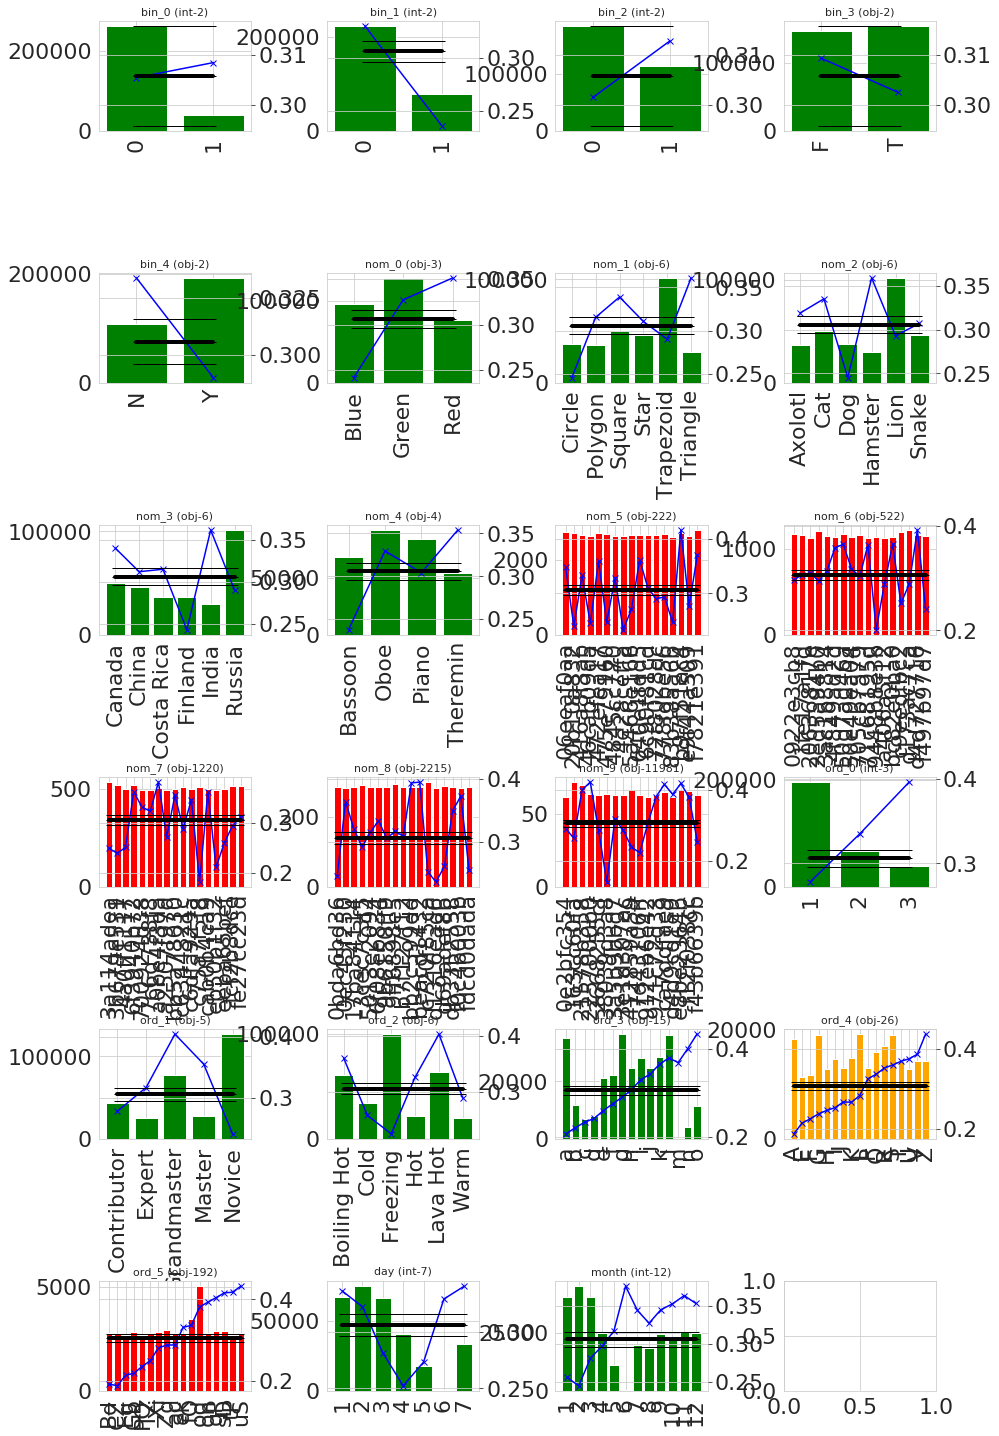

In [25]:
plot_multiple_categorical(train_df, [v for v in list(train_df.columns) if v not in ["target", "id"]], "target", top_n=17) 

<Figure size 432x288 with 0 Axes>

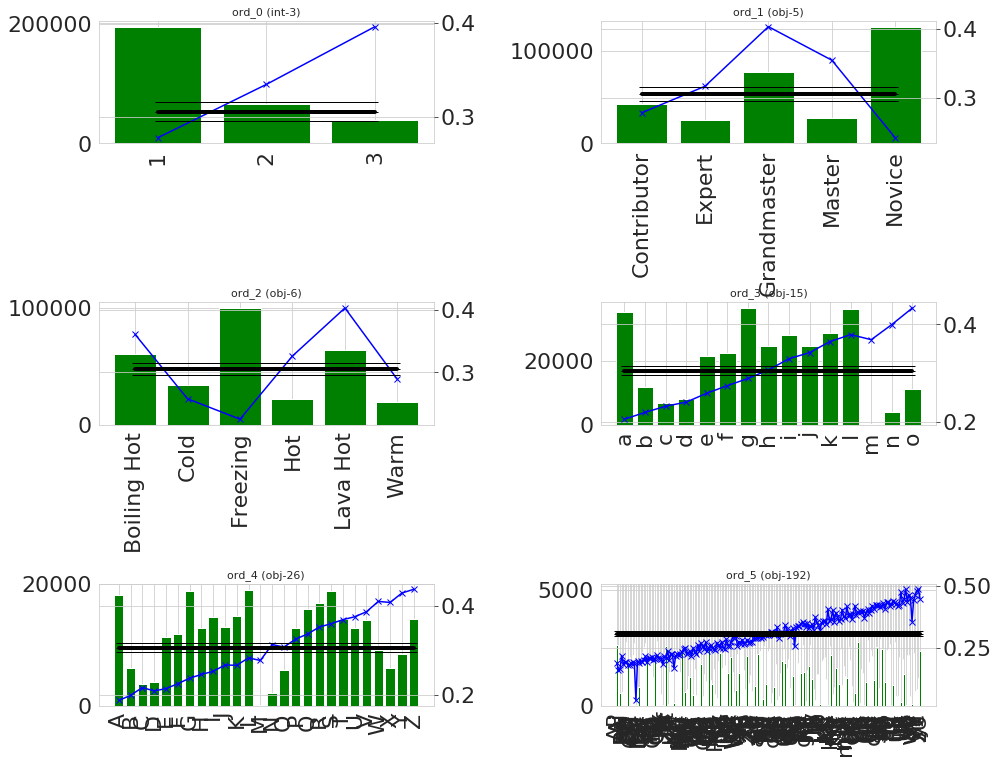

In [26]:
plot_multiple_categorical(train_df, ["ord_0", "ord_1", "ord_2", "ord_3", "ord_4", "ord_5"]
                          , "target", nb_subplots_per_row=2) 